In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import re
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline


In [74]:
SMOOTH_CONFIDENCE_INTERVALS = False  # Set to False for original stepped confidence intervals
SMOOTHING_POINTS = 5  # Number of points for interpolation (higher = smoother)
time_offset_days = 1

In [75]:
import pandas as pd
df = pd.read_csv('Cyano Lysate - K. Rhaeticus Feedstock Experiment 5.14.25.csv', comment=">")
df

,Media,Sample,5.14.25 Replicate #1,5.14.25 Replicate #2,5.15.25 Replicate #1,5.15.25 Replicate #2,5.16.25 Replicate #1,5.16.25 Replicate #2,5.17.25 Replicate #1,5.17.25 Replicate #2,5.18.25 Replicate #1,5.18.25 Replicate #2,5.19.25 Replicate #1,5.19.25 Replicate #2
0,No Glucose,Filtered Cyano 1,0.046,0.046,0.066,0.068,0.107,0.112,0.110,0.111,0.087,0.091,0.092,0.094
1,No Glucose,Filtered Cyano 2,0.096,0.109,0.088,0.071,0.058,0.076,0.049,0.058,0.040,0.036,0.052,0.050
2,No Glucose,Filtered Cyano 3,0.049,0.049,0.065,0.071,0.080,0.088,0.095,0.106,0.076,0.077,0.086,0.087
3,No Glucose,No Cyano 1,0.053,0.054,0.055,0.057,0.097,0.098,0.106,0.116,0.094,0.092,0.108,0.114
4,No Glucose,No Cyano 2,0.049,0.054,0.059,0.058,0.087,0.085,0.093,0.110,0.074,0.076,0.139,0.142
5,No Glucose,No Cyano 3,0.049,0.051,0.076,0.076,0.073,0.089,0.079,0.079,0.080,0.078,0.138,0.138
6,Regular HS,No Cyano 1,0.057,0.058,0.081,0.093,0.094,0.102,0.118,0.120,0.113,0.119,0.167,0.174
7,Regular HS,No Cyano 2,0.081,0.152,0.056,0.058,0.068,0.150,0.073,0.070,0.063,0.066,0.077,0.078
8,Regular HS,No Cyano 3,0.071,0.071,0.269,0.147,0.136,0.143,0.174,0.174,0.172,0.179,0.158,0.194



Summary DataFrame for plotting:
                Combined_Group       Media     Sample_Type  X_Axis_Time_Days  \
0  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               1.0   
1  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               2.0   
2  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               3.0   
3  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               4.0   
4  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               5.0   

    OD_mean   OD_p025   OD_p975   OD_p25   OD_p75  
0  0.065833  0.046000  0.107375  0.04675  0.08425  
1  0.071500  0.065125  0.085875  0.06650  0.07100  
2  0.086833  0.060250  0.111375  0.07700  0.10225  
3  0.088167  0.050125  0.110875  0.06725  0.10900  
4  0.067833  0.036500  0.090500  0.04900  0.08450  

Plot saved as od_plot_combined_groups.png

Processed data with combined groups saved to processed_combined_groups_data.csv
Summary statistics for plot saved to summary_stats

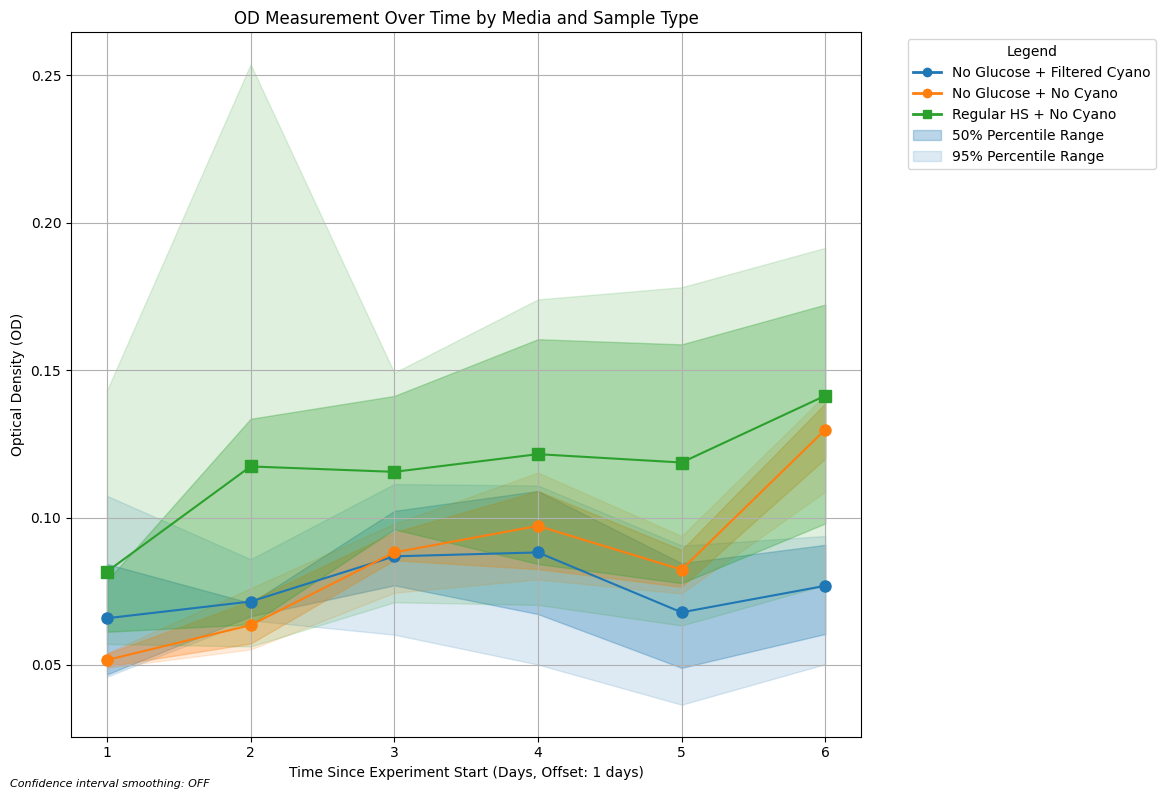

In [76]:

# 2. Reshape Data
df_melted = df.melt(id_vars=['Media', 'Sample'], var_name='Time_Replicate', value_name='OD')

# 3. Parse 'Time_Replicate' column
def parse_time_replicate(time_replicate_str):
    if pd.isna(time_replicate_str): return None, None
    match = re.match(r'(\d{1,2}\.\d{1,2}\.\d{2})\sReplicate\s#(\d+)', time_replicate_str)
    if match:
        date_str, replicate_num_str = match.group(1), match.group(2)
        try:
            date_obj = datetime.strptime(date_str, '%m.%d.%y')
            return date_obj, int(replicate_num_str)
        except ValueError: return None, None
    return None, None

df_melted[['Date', 'Technical_Replicate']] = df_melted['Time_Replicate'].apply(lambda x: pd.Series(parse_time_replicate(x)))
df_melted.dropna(subset=['Date', 'OD'], inplace=True)
df_melted['OD'] = pd.to_numeric(df_melted['OD'], errors='coerce')
df_melted.dropna(subset=['OD'], inplace=True)

# 4. Define Experimental Groups by combining Media and Sample type
def extract_sample_type(sample_name):
    if 'Filtered Cyano' in sample_name:
        return 'Filtered Cyano'
    elif 'No Cyano' in sample_name:
        return 'No Cyano'
    elif 'Unfiltered Cyano' in sample_name:
        return 'Unfiltered Cyano'
    return 'Other'

df_melted['Sample_Type'] = df_melted['Sample'].apply(extract_sample_type)
# Create a new column that combines Media and Sample_Type for grouping
df_melted['Combined_Group'] = df_melted['Media'] + ' + ' + df_melted['Sample_Type']

# 5. Calculate Time
if not df_melted['Date'].empty:
    experiment_start_date = df_melted['Date'].min()
    df_melted['Time_Since_Start_Days'] = (df_melted['Date'] - experiment_start_date).dt.total_seconds() / (24 * 60 * 60)
    
    df_melted['X_Axis_Time_Days'] = df_melted['Time_Since_Start_Days'] + time_offset_days

    # 6. Aggregate Data for Plotting - now by Combined_Group
    agg_funcs = {
        'OD_mean': ('OD', 'mean'),
        'OD_p025': ('OD', lambda x: np.percentile(x, 2.5)),
        'OD_p975': ('OD', lambda x: np.percentile(x, 97.5)),
        'OD_p25': ('OD', lambda x: np.percentile(x, 25)),
        'OD_p75': ('OD', lambda x: np.percentile(x, 75))
    }
    df_summary = df_melted.groupby(['Combined_Group', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**agg_funcs).reset_index()

    print("\nSummary DataFrame for plotting:")
    print(df_summary.head())

    # 7. Plotting
    plt.figure(figsize=(14, 8))
    
    experimental_groups = df_summary['Combined_Group'].unique()
    palette = sns.color_palette(n_colors=len(experimental_groups))
    color_map = dict(zip(experimental_groups, palette))

    # Create a mapping for Media to Matplotlib markers
    unique_media_types = df_summary['Media'].unique()
    available_markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>']
    marker_map = {media: available_markers[i % len(available_markers)] for i, media in enumerate(unique_media_types)}

    # Function to create smooth interpolated lines
    def create_smooth_line(x, y, num_points=SMOOTHING_POINTS):
        # Only interpolate if we have enough points and user wants smoothing
        if len(x) > 2 and SMOOTH_CONFIDENCE_INTERVALS:
            # Create a smooth spline interpolation
            x_new = np.linspace(min(x), max(x), num_points)
            try:
                spl = make_interp_spline(x, y, k=min(3, len(x)-1))  # k is the degree of spline
                y_new = spl(x_new)
                return x_new, y_new
            except Exception as e:
                print(f"Interpolation error: {e}. Falling back to original data.")
                return x, y
        return x, y

    for group_name, group_data in df_summary.groupby('Combined_Group'):
        group_data = group_data.sort_values('X_Axis_Time_Days')
        current_media = group_data['Media'].iloc[0]
        
        x_values = group_data['X_Axis_Time_Days'].values
        y_mean = group_data['OD_mean'].values
        
        plt.plot(x_values, y_mean, 
                 label=group_name, color=color_map[group_name], 
                 marker=marker_map.get(current_media, 'o'),
                 markersize=8, linestyle='-')
        
        # Create smooth confidence intervals
        if SMOOTH_CONFIDENCE_INTERVALS:
            # 95% confidence interval
            x_smooth, lower_95 = create_smooth_line(x_values, group_data['OD_p025'].values)
            _, upper_95 = create_smooth_line(x_values, group_data['OD_p975'].values)
            plt.fill_between(x_smooth, lower_95, upper_95,
                            color=color_map[group_name], alpha=0.15, 
                            label=f'{group_name} 95% range')
            
            # 50% confidence interval
            x_smooth, lower_50 = create_smooth_line(x_values, group_data['OD_p25'].values)
            _, upper_50 = create_smooth_line(x_values, group_data['OD_p75'].values)
            plt.fill_between(x_smooth, lower_50, upper_50,
                            color=color_map[group_name], alpha=0.3, 
                            label=f'{group_name} 50% range')
        else:
            # Original stepped confidence intervals
            plt.fill_between(x_values, group_data['OD_p025'], group_data['OD_p975'],
                         color=color_map[group_name], alpha=0.15, 
                         label=f'{group_name} 95% range')
        
            plt.fill_between(x_values, group_data['OD_p25'], group_data['OD_p75'],
                         color=color_map[group_name], alpha=0.3, 
                         label=f'{group_name} 50% range')

    plt.title('OD Measurement Over Time by Media and Sample Type')
    plt.xlabel(f'Time Since Experiment Start (Days, Offset: {time_offset_days} days)')
    plt.ylabel('Optical Density (OD)')
    
    # Create custom legend
    legend_elements = []
    for group_name in experimental_groups:
        media_for_group = df_summary[df_summary['Combined_Group'] == group_name]['Media'].iloc[0]
        marker_for_legend = marker_map.get(media_for_group, 'o')
        legend_elements.append(Line2D([0], [0], color=color_map[group_name], lw=2, 
                                     marker=marker_for_legend,
                                     label=group_name))
    
    # Add generic patches for ranges
    if not df_summary.empty:
        rep_color = color_map.get(experimental_groups[0], 'gray') if experimental_groups.size > 0 else 'gray'
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.3,
                                   label='50% Percentile Range'))
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.15,
                                   label='95% Percentile Range'))

    plt.legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect for legend

    # Add a note about confidence interval smoothing
    smoothing_status = "ON" if SMOOTH_CONFIDENCE_INTERVALS else "OFF"
    plt.figtext(0.01, 0.01, f"Confidence interval smoothing: {smoothing_status}", 
                fontsize=8, style='italic')

    plot_filename = "od_plot_combined_groups_smooth.png" if SMOOTH_CONFIDENCE_INTERVALS else "od_plot_combined_groups.png"
    plt.savefig(plot_filename, bbox_inches='tight')
    print(f"\nPlot saved as {plot_filename}")

    processed_csv_path = 'processed_combined_groups_data.csv'
    df_melted.to_csv(processed_csv_path, index=False)
    summary_csv_path = 'summary_stats_combined_groups.csv'
    df_summary.to_csv(summary_csv_path, index=False)
    print(f"\nProcessed data with combined groups saved to {processed_csv_path}")
    print(f"Summary statistics for plot saved to {summary_csv_path}")

else:
    print("Could not process the data for plotting due to empty date information.")
    plot_filename = "od_plot_combined_groups.png"
    with open(plot_filename, 'w') as f: f.write("No plot generated.")
    processed_csv_path = 'processed_combined_groups_data.csv'
    summary_csv_path = 'summary_stats_combined_groups.csv'
    pd.DataFrame().to_csv(processed_csv_path, index=False)
    pd.DataFrame().to_csv(summary_csv_path, index=False)
    print(f"\nEmpty data files created: {processed_csv_path}, {summary_csv_path}")



Sample Summary DataFrame:
             Sample       Media     Sample_Type  X_Axis_Time_Days  OD_mean  \
0  Filtered Cyano 1  No Glucose  Filtered Cyano               0.0   0.0460   
1  Filtered Cyano 1  No Glucose  Filtered Cyano               1.0   0.0670   
2  Filtered Cyano 1  No Glucose  Filtered Cyano               2.0   0.1095   
3  Filtered Cyano 1  No Glucose  Filtered Cyano               3.0   0.1105   
4  Filtered Cyano 1  No Glucose  Filtered Cyano               4.0   0.0890   

     OD_std  
0  0.000000  
1  0.001414  
2  0.003536  
3  0.000707  
4  0.002828  

Group Summary DataFrame for plotting:
                Combined_Group       Media     Sample_Type  X_Axis_Time_Days  \
0  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               0.0   
1  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               1.0   
2  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano               2.0   
3  No Glucose + Filtered Cyano  No Glucose  Filtered Cyano   

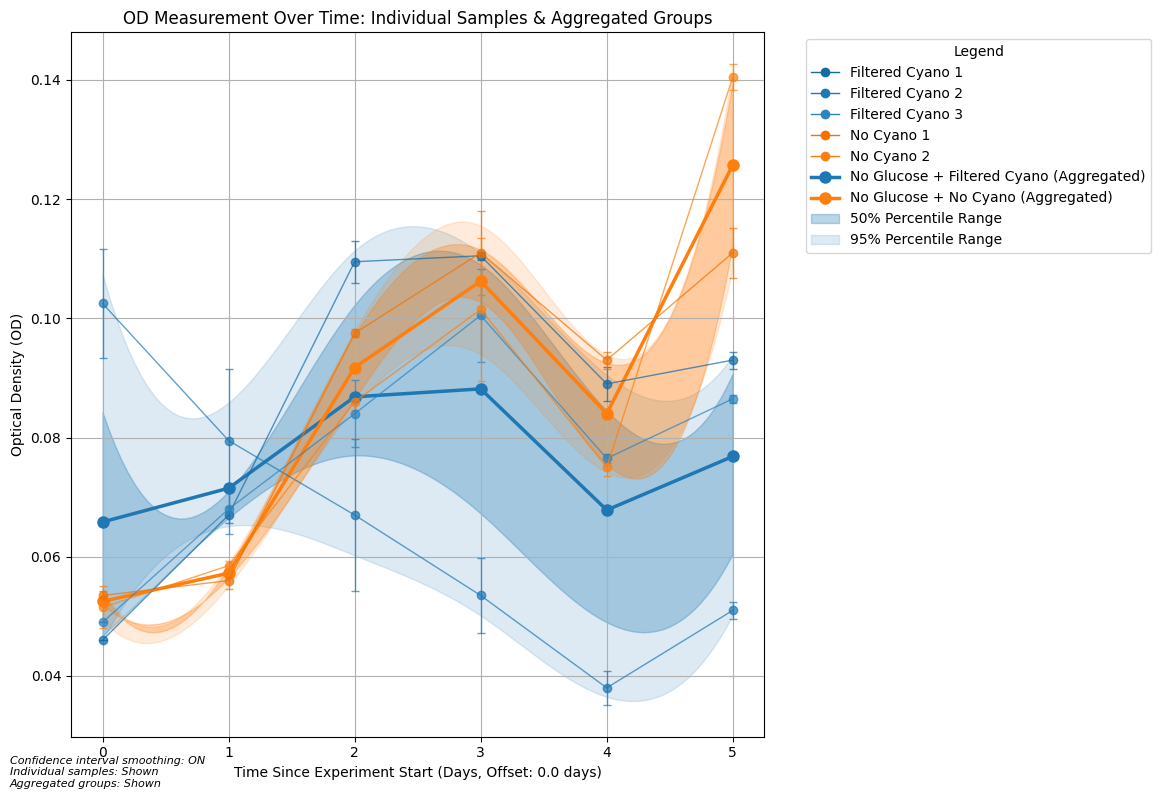

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import re
from datetime import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline

# Configuration options
SMOOTH_CONFIDENCE_INTERVALS = True  # Set to False for original stepped confidence intervals
SMOOTHING_POINTS = 100  # Number of points for interpolation (higher = smoother)
SHOW_INDIVIDUAL_SAMPLES = True  # Show individual sample trajectories
SHOW_AGGREGATED = True  # Show aggregated trajectories by sample type

# 1. Load Data (from CSV string)
csv_data_string = """Media,Sample,5.14.25 Replicate #1,5.14.25 Replicate #2,5.15.25 Replicate #1,5.15.25 Replicate #2,5.16.25 Replicate #1,5.16.25 Replicate #2,5.17.25 Replicate #1,5.17.25 Replicate #2,5.18.25 Replicate #1,5.18.25 Replicate #2,5.19.25 Replicate #1,5.19.25 Replicate #2
No Glucose,Filtered Cyano 1,0.046,0.046,0.066,0.068,0.107,0.112,0.11,0.111,0.087,0.091,0.092,0.094
No Glucose,Filtered Cyano 2,0.096,0.109,0.088,0.071,0.058,0.076,0.049,0.058,0.04,0.036,0.052,0.05
No Glucose,Filtered Cyano 3,0.049,0.049,0.065,0.071,0.08,0.088,0.095,0.106,0.076,0.077,0.086,0.087
No Glucose,No Cyano 1,0.053,0.054,0.055,0.057,0.097,0.098,0.106,0.116,0.094,0.092,0.108,0.114
No Glucose,No Cyano 2,0.049,0.054,0.059,0.058,0.087,0.085,0.093,0.11,0.074,0.076,0.139,0.142
"""

df = pd.read_csv(io.StringIO(csv_data_string), sep=',')

# 2. Reshape Data
df_melted = df.melt(id_vars=['Media', 'Sample'], var_name='Time_Replicate', value_name='OD')

# 3. Parse 'Time_Replicate' column
def parse_time_replicate(time_replicate_str):
    if pd.isna(time_replicate_str): return None, None
    match = re.match(r'(\d{1,2}\.\d{1,2}\.\d{2})\sReplicate\s#(\d+)', time_replicate_str)
    if match:
        date_str, replicate_num_str = match.group(1), match.group(2)
        try:
            date_obj = datetime.strptime(date_str, '%m.%d.%y')
            return date_obj, int(replicate_num_str)
        except ValueError: return None, None
    return None, None

df_melted[['Date', 'Technical_Replicate']] = df_melted['Time_Replicate'].apply(lambda x: pd.Series(parse_time_replicate(x)))
df_melted.dropna(subset=['Date', 'OD'], inplace=True)
df_melted['OD'] = pd.to_numeric(df_melted['OD'], errors='coerce')
df_melted.dropna(subset=['OD'], inplace=True)

# 4. Define Experimental Groups by combining Media and Sample type
def extract_sample_type(sample_name):
    if 'Filtered Cyano' in sample_name:
        return 'Filtered Cyano'
    elif 'No Cyano' in sample_name:
        return 'No Cyano'
    return 'Other'

df_melted['Sample_Type'] = df_melted['Sample'].apply(extract_sample_type)
# Create a new column that combines Media and Sample_Type for grouping
df_melted['Combined_Group'] = df_melted['Media'] + ' + ' + df_melted['Sample_Type']

# 5. Calculate Time
if not df_melted['Date'].empty:
    experiment_start_date = df_melted['Date'].min()
    df_melted['Time_Since_Start_Days'] = (df_melted['Date'] - experiment_start_date).dt.total_seconds() / (24 * 60 * 60)
    time_offset_days = 0.0
    df_melted['X_Axis_Time_Days'] = df_melted['Time_Since_Start_Days'] + time_offset_days

    # 6. Prepare data for individual samples and aggregated groups
    
    # First, calculate statistics across technical replicates for each sample
    sample_agg_funcs = {
        'OD_mean': ('OD', 'mean'),
        'OD_std': ('OD', 'std')  # Standard deviation across technical replicates
    }
    df_sample_summary = df_melted.groupby(['Sample', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**sample_agg_funcs).reset_index()
    print("\nSample Summary DataFrame:")
    print(df_sample_summary.head())
    
    # Then aggregate by Combined_Group for the grouped visualization
    group_agg_funcs = {
        'OD_mean': ('OD', 'mean'),
        'OD_p025': ('OD', lambda x: np.percentile(x, 2.5)),
        'OD_p975': ('OD', lambda x: np.percentile(x, 97.5)),
        'OD_p25': ('OD', lambda x: np.percentile(x, 25)),
        'OD_p75': ('OD', lambda x: np.percentile(x, 75))
    }
    df_group_summary = df_melted.groupby(['Combined_Group', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**group_agg_funcs).reset_index()
    
    print("\nGroup Summary DataFrame for plotting:")
    print(df_group_summary.head())

    # 7. Plotting
    plt.figure(figsize=(14, 8))
    
    # Create color maps for both sample types and individual samples
    group_types = df_melted['Combined_Group'].unique()
    group_palette = sns.color_palette("tab10", n_colors=len(group_types))
    group_color_map = dict(zip(group_types, group_palette))
    
    samples = df_melted['Sample'].unique()
    # Use a color palette that's related to the group colors but with variations
    sample_palette = []
    for group in group_types:
        sample_type = group.split(' + ')[1]
        group_samples = [s for s in samples if sample_type in s]
        # For each group, create slightly varied shades of the group color
        base_color = group_color_map[group]
        sample_colors = []
        for i in range(len(group_samples)):
            # Slightly modify the base color for each sample
            modified_color = [
                max(0, min(1, base_color[0] + (i-1)*0.05)),
                max(0, min(1, base_color[1] + (i-1)*0.05)),
                max(0, min(1, base_color[2] + (i-1)*0.05))
            ]
            sample_colors.append(modified_color)
        sample_palette.extend(sample_colors)
    
    # Create a mapping from sample to color
    sample_color_map = dict(zip(samples, sample_palette[:len(samples)]))
    
    # Create a mapping for Media to Matplotlib markers
    unique_media_types = df_melted['Media'].unique()
    available_markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>']
    marker_map = {media: available_markers[i % len(available_markers)] for i, media in enumerate(unique_media_types)}

    # Function to create smooth interpolated lines
    def create_smooth_line(x, y, num_points=SMOOTHING_POINTS):
        # Only interpolate if we have enough points and user wants smoothing
        if len(x) > 2 and SMOOTH_CONFIDENCE_INTERVALS:
            # Create a smooth spline interpolation
            x_new = np.linspace(min(x), max(x), num_points)
            try:
                spl = make_interp_spline(x, y, k=min(3, len(x)-1))  # k is the degree of spline
                y_new = spl(x_new)
                return x_new, y_new
            except Exception as e:
                print(f"Interpolation error: {e}. Falling back to original data.")
                return x, y
        return x, y
    
    # Plot individual sample trajectories if enabled
    if SHOW_INDIVIDUAL_SAMPLES:
        for sample_name, sample_data in df_sample_summary.groupby('Sample'):
            sample_data = sample_data.sort_values('X_Axis_Time_Days')
            
            # Get the combined group for this sample to determine color
            sample_type = sample_data['Sample_Type'].iloc[0]
            media = sample_data['Media'].iloc[0]
            combined_group = f"{media} + {sample_type}"
            
            # If specific sample color is available use it, otherwise fall back to group color
            color = sample_color_map.get(sample_name, group_color_map.get(combined_group, 'gray'))
            
            x_values = sample_data['X_Axis_Time_Days'].values
            y_values = sample_data['OD_mean'].values
            error = sample_data['OD_std'].values
            
            # Plot the individual sample line
            plt.errorbar(x_values, y_values, yerr=error, 
                      label=sample_name, color=color, 
                      marker=marker_map.get(media, 'o'),
                      markersize=6, linestyle='-', linewidth=1.0,
                      elinewidth=1, capsize=3, alpha=0.7)
    
    # Plot aggregated group trajectories if enabled
    if SHOW_AGGREGATED:
        for group_name, group_data in df_group_summary.groupby('Combined_Group'):
            group_data = group_data.sort_values('X_Axis_Time_Days')
            current_media = group_data['Media'].iloc[0]
            
            x_values = group_data['X_Axis_Time_Days'].values
            y_mean = group_data['OD_mean'].values
            
            # Plot with thicker line to distinguish from individual samples
            plt.plot(x_values, y_mean, 
                     label=f"{group_name} (Aggregated)", color=group_color_map[group_name], 
                     marker=marker_map.get(current_media, 'o'),
                     markersize=8, linestyle='-', linewidth=2.5)
            
            # Create smooth confidence intervals if enabled
            if SMOOTH_CONFIDENCE_INTERVALS:
                # 95% confidence interval
                x_smooth, lower_95 = create_smooth_line(x_values, group_data['OD_p025'].values)
                _, upper_95 = create_smooth_line(x_values, group_data['OD_p975'].values)
                plt.fill_between(x_smooth, lower_95, upper_95,
                                color=group_color_map[group_name], alpha=0.15, 
                                label=f'{group_name} 95% range')
                
                # 50% confidence interval
                x_smooth, lower_50 = create_smooth_line(x_values, group_data['OD_p25'].values)
                _, upper_50 = create_smooth_line(x_values, group_data['OD_p75'].values)
                plt.fill_between(x_smooth, lower_50, upper_50,
                                color=group_color_map[group_name], alpha=0.3, 
                                label=f'{group_name} 50% range')
            else:
                # Original stepped confidence intervals
                plt.fill_between(x_values, group_data['OD_p025'], group_data['OD_p975'],
                             color=group_color_map[group_name], alpha=0.15, 
                             label=f'{group_name} 95% range')
            
                plt.fill_between(x_values, group_data['OD_p25'], group_data['OD_p75'],
                             color=group_color_map[group_name], alpha=0.3, 
                             label=f'{group_name} 50% range')

    plt.title('OD Measurement Over Time: Individual Samples & Aggregated Groups')
    plt.xlabel(f'Time Since Experiment Start (Days, Offset: {time_offset_days} days)')
    plt.ylabel('Optical Density (OD)')
    
    # Create custom legend with filtered elements to avoid overcrowding
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Filter the legend to show:
    # 1. Individual samples if they're shown
    # 2. Aggregated group lines if they're shown
    # 3. Only one representation each of 50% and 95% ranges
    
    legend_elements = []
    seen_range_50 = False
    seen_range_95 = False
    
    # First, add individual samples if they're enabled
    if SHOW_INDIVIDUAL_SAMPLES:
        for sample_name in samples:
            media = df_melted[df_melted['Sample'] == sample_name]['Media'].iloc[0]
            color = sample_color_map.get(sample_name, 'gray')
            marker = marker_map.get(media, 'o')
            # Create error bar representation for legend
            legend_elements.append(Line2D([0], [0], color=color, lw=1.0, marker=marker,
                                         markersize=6, label=sample_name))
    
    # Then add aggregated groups if they're enabled
    if SHOW_AGGREGATED:
        for group_name in group_types:
            media = df_melted[df_melted['Combined_Group'] == group_name]['Media'].iloc[0]
            color = group_color_map.get(group_name, 'gray')
            marker = marker_map.get(media, 'o')
            legend_elements.append(Line2D([0], [0], color=color, lw=2.5, marker=marker,
                                         markersize=8, label=f"{group_name} (Aggregated)"))
    
    # Finally add one example each of the range patches
    if not df_group_summary.empty and SHOW_AGGREGATED:
        rep_color = group_color_map.get(group_types[0], 'gray') if len(group_types) > 0 else 'gray'
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.3,
                                   label='50% Percentile Range'))
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.15,
                                   label='95% Percentile Range'))

    # Create the legend with a scrollable box if there are many elements
    if len(legend_elements) > 10:
        plt.legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), 
                  loc='upper left', ncol=1, frameon=True, fontsize='small')
    else:
        plt.legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), 
                  loc='upper left')
    
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect for legend

    # Add notes about configuration
    notes = []
    notes.append(f"Confidence interval smoothing: {'ON' if SMOOTH_CONFIDENCE_INTERVALS else 'OFF'}")
    notes.append(f"Individual samples: {'Shown' if SHOW_INDIVIDUAL_SAMPLES else 'Hidden'}")
    notes.append(f"Aggregated groups: {'Shown' if SHOW_AGGREGATED else 'Hidden'}")
    note_text = "\n".join(notes)
    plt.figtext(0.01, 0.01, note_text, fontsize=8, style='italic')

    # Determine filename based on configuration
    filename_parts = []
    if SHOW_INDIVIDUAL_SAMPLES: filename_parts.append("individual")
    if SHOW_AGGREGATED: filename_parts.append("aggregated")
    if SMOOTH_CONFIDENCE_INTERVALS: filename_parts.append("smooth")
    
    plot_filename = f"od_plot_{'_'.join(filename_parts)}.png"
    plt.savefig(plot_filename, bbox_inches='tight')
    print(f"\nPlot saved as {plot_filename}")

    # Save processed data
    processed_csv_path = 'processed_samples_and_groups_data.csv'
    df_melted.to_csv(processed_csv_path, index=False)
    
    # Save summary stats for both individual samples and groups
    sample_summary_csv_path = 'summary_stats_individual_samples.csv'
    df_sample_summary.to_csv(sample_summary_csv_path, index=False)
    
    group_summary_csv_path = 'summary_stats_aggregated_groups.csv'
    df_group_summary.to_csv(group_summary_csv_path, index=False)
    
    print(f"\nProcessed data saved to {processed_csv_path}")
    print(f"Individual sample statistics saved to {sample_summary_csv_path}")
    print(f"Aggregated group statistics saved to {group_summary_csv_path}")

else:
    print("Could not process the data for plotting due to empty date information.")
    plot_filename = "od_plot_no_data.png"
    with open(plot_filename, 'w') as f: f.write("No plot generated.")
    processed_csv_path = 'processed_samples_and_groups_data.csv'
    sample_summary_csv_path = 'summary_stats_individual_samples.csv'
    group_summary_csv_path = 'summary_stats_aggregated_groups.csv'
    pd.DataFrame().to_csv(processed_csv_path, index=False)
    pd.DataFrame().to_csv(sample_summary_csv_path, index=False)
    pd.DataFrame().to_csv(group_summary_csv_path, index=False)
    print(f"\nEmpty data files created: {processed_csv_path}, {sample_summary_csv_path}, {group_summary_csv_path}")